In [ ]:
!pip install flask

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from math import log2
from tld import get_tld
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,Dropout
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix


In [4]:
# Load data
data = pd.read_csv('Domain_names.csv')

# Extracted Features
data['Domain Length'] = data['Domain Names'].apply(len)
data['Subdomain Count'] = data['Domain Names'].apply(lambda x: x.count('.'))
data['TLD Length'] = data['Domain Names'].apply(lambda x: len(x.split('.')[-1]))
data['Hyphen Count'] = data['Domain Names'].apply(lambda x: x.count('-'))
data['Numeric Frequency'] = data['Domain Names'].apply(lambda x: sum(c.isdigit() for c in x))
data['Vowel Count'] = data['Domain Names'].apply(lambda x: sum(c in 'aeiou' for c in x.lower()))
data['Consonant Count'] = data['Domain Names'].apply(lambda x: sum(c.isalpha() and c not in 'aeiou' for c in x.lower()))

def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum(count/lns * log2(count/lns) for count in p.values())
data['Entropy Score'] = data['Domain Names'].apply(entropy)

domain_rank = np.random.randint(1, 1000, size=len(data))

common_words = ['bank', 'secure', 'payment', 'login', 'paypal', 'account']
data['Common Words Count'] = data['Domain Names'].apply(lambda x: sum(word in x.lower() for word in common_words))

data['Domain Parts Count'] = data['Domain Names'].apply(lambda x: len(x.split('.')))
data['Dots Count'] = data['Domain Names'].apply(lambda x: x.count('.'))


n=3
tokenizer = Tokenizer(char_level =True, filters='')
tokenizer.fit_on_texts(data['Domain Names'])
data['n_grams'] = tokenizer.texts_to_sequences(data['Domain Names'])



# Save the modified DataFrame to the same CSV file
data.to_csv('Domain_names.csv', index=False)


In [5]:
df = pd.read_csv("Domain_names.csv")

In [6]:
df.head()

,Label,Origin,Domain Names,Domain Length,Subdomain Count,TLD Length,Hyphen Count,Numeric Frequency,Vowel Count,Consonant Count,Entropy Score,Common Words Count,Domain Parts Count,Dots Count,n_grams
0,dga,corebot,cvyh1po636avyrsxebwbkn7.ddns.net,32,2,3,0,5,4,21,4.351410,0,3,2,"[4, 23, 21, 20, 31, 16, 1, 32, 34, 32, 5, 23, ..."
1,legit,alexa,plasticbags.sa.com,18,2,3,0,0,5,11,3.419382,0,3,2,"[16, 13, 5, 11, 10, 7, 4, 17, 5, 15, 11, 3, 11..."
2,legit,alexa,mzltrack.com,12,1,3,0,0,2,9,3.251629,0,2,1,"[6, 27, 13, 10, 9, 5, 4, 18, 3, 4, 1, 6]"
3,legit,alexa,miss-slim.ru,12,1,2,1,0,3,7,2.855389,0,2,1,"[6, 7, 11, 11, 28, 11, 13, 7, 6, 3, 9, 12]"
4,dga,ranbyus,txumyqrubwutbb.cc,17,1,2,0,0,3,13,3.292770,0,2,1,"[10, 25, 12, 6, 21, 24, 9, 12, 17, 22, 12, 10,..."


In [7]:
df.shape

(674897, 15)

In [8]:
df.count()

Label                 674897
Origin                674897
Domain Names          674897
Domain Length         674897
Subdomain Count       674897
TLD Length            674897
Hyphen Count          674897
Numeric Frequency     674897
Vowel Count           674897
Consonant Count       674897
Entropy Score         674897
Common Words Count    674897
Domain Parts Count    674897
Dots Count            674897
n_grams               674897
dtype: int64

In [9]:
df['Common Words Count'].value_counts()

0    673039
1      1842
2        15
3         1
Name: Common Words Count, dtype: int64

In [10]:
df['Domain Parts Count'].value_counts()

2    585809
3     86999
4      2084
5         5
Name: Domain Parts Count, dtype: int64

In [11]:
df['TLD Length'].value_counts()

3     428171
2     220449
4      21529
6       2152
7       1092
5        956
8        410
9         68
10        35
11        15
13        10
12         9
14         1
Name: TLD Length, dtype: int64

In [12]:
df['Entropy Score'].value_counts()

3.251629    14845
3.521641    11509
3.095795    11400
3.392747    11055
3.121928    10494
            ...  
3.574418        1
3.710669        1
3.693223        1
4.697846        1
3.624881        1
Name: Entropy Score, Length: 9116, dtype: int64

In [13]:
df.columns

Index(['Label', 'Origin', 'Domain Names', 'Domain Length', 'Subdomain Count',
       'TLD Length', 'Hyphen Count', 'Numeric Frequency', 'Vowel Count',
       'Consonant Count', 'Entropy Score', 'Common Words Count',
       'Domain Parts Count', 'Dots Count', 'n_grams'],
      dtype='object')

In [14]:
df['Domain Length'].value_counts()

16    57755
14    54883
11    53591
20    52545
12    48864
19    45623
13    43276
15    42747
17    34836
18    32496
10    28395
21    28289
22    25705
9     18671
24    16256
23    14875
8     11966
28    10778
32     7140
7      6636
25     5871
26     5327
29     4494
27     4483
30     4049
31     3702
6      1938
33     1779
34     1215
42      977
41      958
43      823
40      735
35      650
44      578
39      451
36      397
45      290
37      287
38      274
46      159
47       59
48       31
73        9
49        7
51        5
53        4
50        4
52        4
72        2
64        2
71        1
54        1
60        1
67        1
63        1
62        1
Name: Domain Length, dtype: int64

In [15]:
df['Label'].value_counts()

dga      337499
legit    337398
Name: Label, dtype: int64

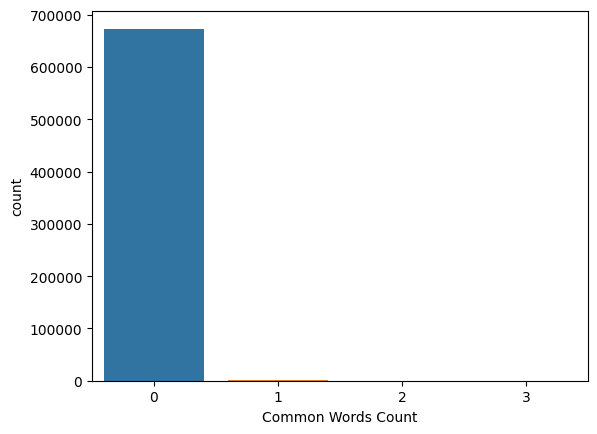

In [16]:
sns.countplot(data=df,x='Common Words Count')
plt.show()

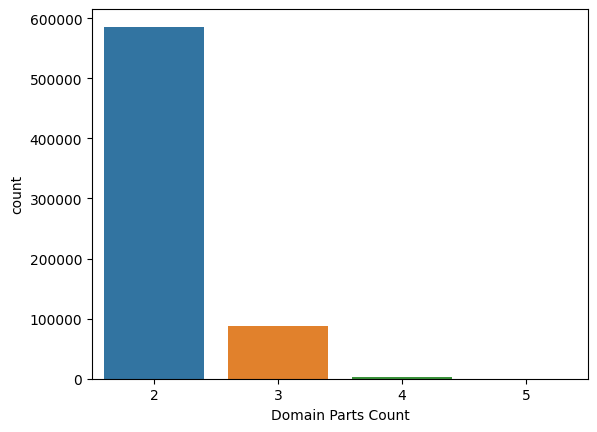

In [17]:
sns.countplot(data=df,x='Domain Parts Count')
plt.show()

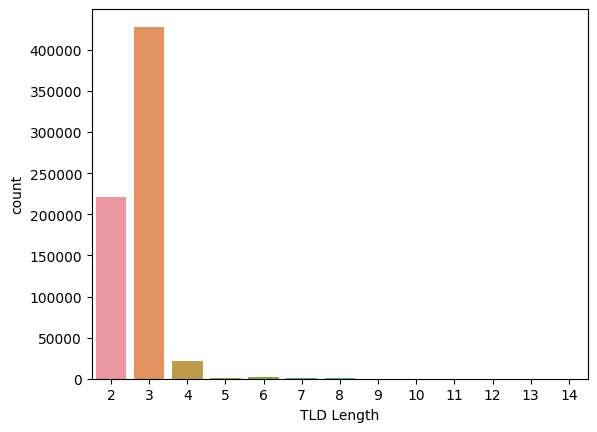

In [18]:
sns.countplot(data=df,x='TLD Length')
plt.show()

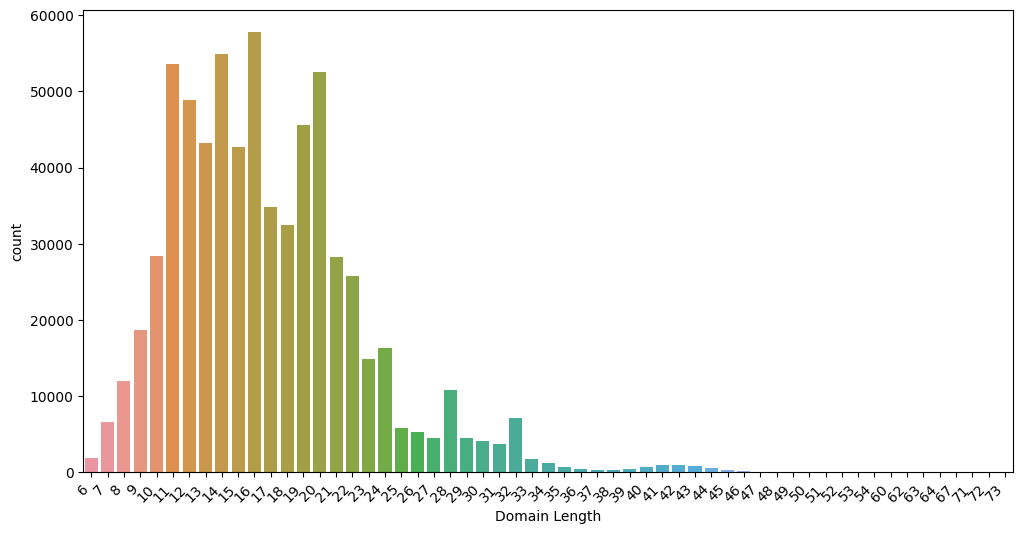

In [19]:
plt.figure(figsize=(12,6))
ax=sns.countplot(data=df,x='Domain Length')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha ='right')
plt.show()

In [20]:
#Here after encoding 

#0 ----> DGA
#1 ------> Legit


label = LabelEncoder()
df['label'] = label.fit_transform(df['Label'])

In [21]:
df['label'].value_counts()

0    337499
1    337398
Name: label, dtype: int64

In [22]:
df.columns

Index(['Label', 'Origin', 'Domain Names', 'Domain Length', 'Subdomain Count',
       'TLD Length', 'Hyphen Count', 'Numeric Frequency', 'Vowel Count',
       'Consonant Count', 'Entropy Score', 'Common Words Count',
       'Domain Parts Count', 'Dots Count', 'n_grams', 'label'],
      dtype='object')

In [23]:
df = df.drop(['Label'],axis=1)

In [24]:
df.columns

Index(['Origin', 'Domain Names', 'Domain Length', 'Subdomain Count',
       'TLD Length', 'Hyphen Count', 'Numeric Frequency', 'Vowel Count',
       'Consonant Count', 'Entropy Score', 'Common Words Count',
       'Domain Parts Count', 'Dots Count', 'n_grams', 'label'],
      dtype='object')

In [25]:
df.head()

,Origin,Domain Names,Domain Length,Subdomain Count,TLD Length,Hyphen Count,Numeric Frequency,Vowel Count,Consonant Count,Entropy Score,Common Words Count,Domain Parts Count,Dots Count,n_grams,label
0,corebot,cvyh1po636avyrsxebwbkn7.ddns.net,32,2,3,0,5,4,21,4.351410,0,3,2,"[4, 23, 21, 20, 31, 16, 1, 32, 34, 32, 5, 23, ...",0
1,alexa,plasticbags.sa.com,18,2,3,0,0,5,11,3.419382,0,3,2,"[16, 13, 5, 11, 10, 7, 4, 17, 5, 15, 11, 3, 11...",1
2,alexa,mzltrack.com,12,1,3,0,0,2,9,3.251629,0,2,1,"[6, 27, 13, 10, 9, 5, 4, 18, 3, 4, 1, 6]",1
3,alexa,miss-slim.ru,12,1,2,1,0,3,7,2.855389,0,2,1,"[6, 7, 11, 11, 28, 11, 13, 7, 6, 3, 9, 12]",1
4,ranbyus,txumyqrubwutbb.cc,17,1,2,0,0,3,13,3.292770,0,2,1,"[10, 25, 12, 6, 21, 24, 9, 12, 17, 22, 12, 10,...",0


In [26]:
df.dtypes

Origin                 object
Domain Names           object
Domain Length           int64
Subdomain Count         int64
TLD Length              int64
Hyphen Count            int64
Numeric Frequency       int64
Vowel Count             int64
Consonant Count         int64
Entropy Score         float64
Common Words Count      int64
Domain Parts Count      int64
Dots Count              int64
n_grams                object
label                   int32
dtype: object

In [27]:
num_col = []
for i in df.columns:
    if df[i].dtypes == 'int64' or df[i].dtypes == 'float64' or df[i].dtypes=='int32':
        num_col.append(i)
        
        
print(num_col)

['Domain Length', 'Subdomain Count', 'TLD Length', 'Hyphen Count', 'Numeric Frequency', 'Vowel Count', 'Consonant Count', 'Entropy Score', 'Common Words Count', 'Domain Parts Count', 'Dots Count', 'label']


C:\Users\shubh\AppData\Local\Temp\ipykernel_3552\2943803821.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


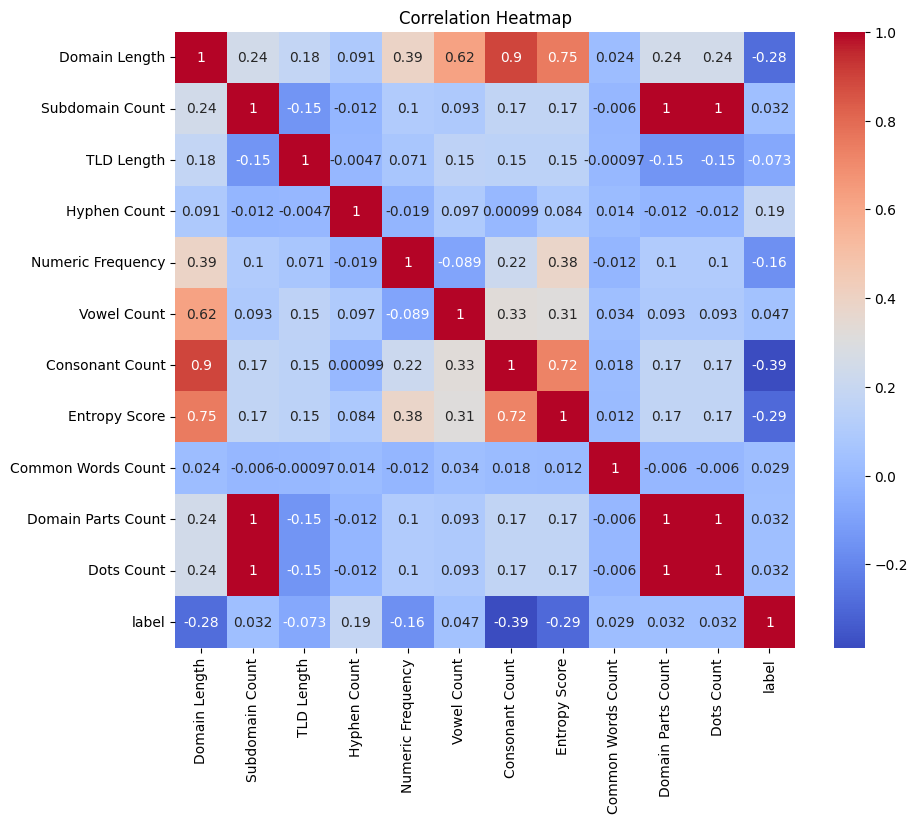

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [29]:
num_col

['Domain Length',
 'Subdomain Count',
 'TLD Length',
 'Hyphen Count',
 'Numeric Frequency',
 'Vowel Count',
 'Consonant Count',
 'Entropy Score',
 'Common Words Count',
 'Domain Parts Count',
 'Dots Count',
 'label']

In [30]:
new_df = df[num_col]

In [31]:
new_df.columns

Index(['Domain Length', 'Subdomain Count', 'TLD Length', 'Hyphen Count',
       'Numeric Frequency', 'Vowel Count', 'Consonant Count', 'Entropy Score',
       'Common Words Count', 'Domain Parts Count', 'Dots Count', 'label'],
      dtype='object')

In [32]:
new_df.head()

,Domain Length,Subdomain Count,TLD Length,Hyphen Count,Numeric Frequency,Vowel Count,Consonant Count,Entropy Score,Common Words Count,Domain Parts Count,Dots Count,label
0,32,2,3,0,5,4,21,4.351410,0,3,2,0
1,18,2,3,0,0,5,11,3.419382,0,3,2,1
2,12,1,3,0,0,2,9,3.251629,0,2,1,1
3,12,1,2,1,0,3,7,2.855389,0,2,1,1
4,17,1,2,0,0,3,13,3.292770,0,2,1,0


In [33]:
new_df[num_col]

,Domain Length,Subdomain Count,TLD Length,Hyphen Count,Numeric Frequency,Vowel Count,Consonant Count,Entropy Score,Common Words Count,Domain Parts Count,Dots Count,label
0,32,2,3,0,5,4,21,4.351410,0,3,2,0
1,18,2,3,0,0,5,11,3.419382,0,3,2,1
2,12,1,3,0,0,2,9,3.251629,0,2,1,1
3,12,1,2,1,0,3,7,2.855389,0,2,1,1
4,17,1,2,0,0,3,13,3.292770,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
674892,20,1,3,0,0,3,16,3.041446,0,2,1,0
674893,19,1,2,0,0,3,15,3.642150,0,2,1,0
674894,10,1,3,0,0,3,6,3.121928,0,2,1,1
674895,18,1,3,0,0,4,13,3.836592,0,2,1,0


In [34]:
X = new_df.drop('label', axis=1)
y = new_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (if needed)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [35]:
classifiers = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('k-Nearest Neighbors', KNeighborsClassifier())
]

for name, clf in classifiers:
    clf.fit(X_train_scaled, y_train)  # Train the classifier
    y_pred = clf.predict(X_test_scaled)  # Predict on test data
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    confusion = confusion_matrix(y_test, y_pred)  # Confusion matrix

    print(f"Classifier: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(confusion)
    print("=" * 40)

Classifier: Logistic Regression
Accuracy: 0.7055
Confusion Matrix:
[[44426 22888]
 [16859 50807]]
Classifier: Decision Tree
Accuracy: 0.8206
Confusion Matrix:
[[51613 15701]
 [ 8517 59149]]
Classifier: Random Forest
Accuracy: 0.8219
Confusion Matrix:
[[51447 15867]
 [ 8172 59494]]
Classifier: k-Nearest Neighbors
Accuracy: 0.7979
Confusion Matrix:
[[51933 15381]
 [11898 55768]]


In [36]:
catboost_model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1,verbose=100)
catboost_model.fit(X_train,y_train)

0:	learn: 0.6555897	total: 251ms	remaining: 4m 10s
100:	learn: 0.3976752	total: 8.88s	remaining: 1m 19s
200:	learn: 0.3825898	total: 17.4s	remaining: 1m 9s
300:	learn: 0.3770761	total: 26.3s	remaining: 1m
400:	learn: 0.3738234	total: 34.9s	remaining: 52.1s
500:	learn: 0.3721615	total: 44.2s	remaining: 44s
600:	learn: 0.3707848	total: 53s	remaining: 35.2s
700:	learn: 0.3698210	total: 1m 1s	remaining: 26.2s
800:	learn: 0.3690775	total: 1m 9s	remaining: 17.3s
900:	learn: 0.3684260	total: 1m 17s	remaining: 8.56s
999:	learn: 0.3677166	total: 1m 26s	remaining: 0us


In [37]:
y_pred_catboost = catboost_model.predict(X_test)
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
conf_matrix_catboost = confusion_matrix(y_test,y_pred_catboost)

print("CatBoost Model: ")
print(f"Accuracy: {accuracy_catboost: .4f}")
print("Confusion Matrix")
print(conf_matrix_catboost)

CatBoost Model: 
Accuracy:  0.8253
Confusion Matrix
[[51438 15876]
 [ 7703 59963]]


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create a subset of the data for faster testing (you can adjust the sample size)
sample_size = 20000
X_train_subset = X_train[:sample_size]
y_train_subset = y_train[:sample_size]

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [200],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Perform Grid Search with reduced parameter grid and smaller dataset
grid_rf = GridSearchCV(rf_classifier, param_grid, cv=3, n_jobs=-1)
grid_rf.fit(X_train_subset, y_train_subset)

# Get the best parameters
best_rf_params = grid_rf.best_params_

# Initialize a new Random Forest model with the best parameters
best_rf_model = RandomForestClassifier(**best_rf_params)
best_rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Calculate accuracy and other metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

# Print results
print("Random Forest Results:")
print("Best Parameters:", best_rf_params)
print("Accuracy:", accuracy_rf)
print("Confusion Matrix:\n", conf_matrix_rf)
print("Classification Report:\n", classification_rep_rf)


Random Forest Results:
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.8221958808712402
Confusion Matrix:
 [[51400 15914]
 [ 8086 59580]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.76      0.81     67314
           1       0.79      0.88      0.83     67666

    accuracy                           0.82    134980
   macro avg       0.83      0.82      0.82    134980
weighted avg       0.83      0.82      0.82    134980



In [39]:
'''param_grid = {
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'criterion': ['gini', 'entropy']
}

dt_classifier = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_classifier,param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
print("Best Hyper parameters are: ",best_params)

best_models = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test,y_pred)

print("Best Decision Tree Model:")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
'''

'param_grid = {\n    \'max_depth\': [10, 20],\n    \'min_samples_split\': [5, 10],\n    \'min_samples_leaf\': [2, 4],\n    \'criterion\': [\'gini\', \'entropy\']\n}\n\ndt_classifier = DecisionTreeClassifier()\n\ngrid_search = GridSearchCV(dt_classifier,param_grid, cv=5, n_jobs=-1, verbose=2)\ngrid_search.fit(X_train,y_train)\n\nbest_params = grid_search.best_params_\nprint("Best Hyper parameters are: ",best_params)\n\nbest_models = grid_search.best_estimator_\ny_pred = best_model.predict(X_test)\n\naccuracy = accuracy_score(y_test, y_pred)\nconf_matrix = confusion_matrix(y_test,y_pred)\n\nprint("Best Decision Tree Model:")\nprint(f"Accuracy: {accuracy:.4f}")\nprint("Confusion Matrix:")\nprint(conf_matrix)\n'

In [40]:

'''param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200, 300],
}

logreg = LogisticRegression()


grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Best Model:", best_model)
print(f"Accuracy on Test Set: {accuracy:.4f}")
'''


'param_grid = {\n    \'C\': [0.001, 0.01, 0.1, 1, 10, 100],\n    \'penalty\': [\'l1\', \'l2\'],\n    \'max_iter\': [100, 200, 300],\n}\n\nlogreg = LogisticRegression()\n\n\ngrid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring=\'accuracy\')\ngrid_search.fit(X_train, y_train)\n\n\nbest_params = grid_search.best_params_\nbest_model = grid_search.best_estimator_\n\ny_pred = best_model.predict(X_test)\naccuracy = accuracy_score(y_test, y_pred)\n\nprint("Best Hyperparameters:", best_params)\nprint("Best Model:", best_model)\nprint(f"Accuracy on Test Set: {accuracy:.4f}")\n'

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

In [42]:


model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape=(X_train_scaled.shape[1], 1), return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(64))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_lstm.fit(X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1],1),
              y_train, epochs=10,batch_size=64, validation_split=0.2, verbose=1)
              


Epoch 1/10
6749/6749 [==============================] - 136s 20ms/step - loss: 0.4612 - accuracy: 0.7720 - val_loss: 0.4040 - val_accuracy: 0.8109
Epoch 2/10
6749/6749 [==============================] - 134s 20ms/step - loss: 0.4078 - accuracy: 0.8098 - val_loss: 0.3887 - val_accuracy: 0.8175
Epoch 3/10
6749/6749 [==============================] - 134s 20ms/step - loss: 0.3972 - accuracy: 0.8155 - val_loss: 0.3853 - val_accuracy: 0.8195
Epoch 4/10
6749/6749 [==============================] - 134s 20ms/step - loss: 0.3917 - accuracy: 0.8176 - val_loss: 0.3818 - val_accuracy: 0.8199
Epoch 5/10
6749/6749 [==============================] - 134s 20ms/step - loss: 0.3884 - accuracy: 0.8191 - val_loss: 0.3808 - val_accuracy: 0.8213
Epoch 6/10
6749/6749 [==============================] - 134s 20ms/step - loss: 0.3863 - accuracy: 0.8199 - val_loss: 0.3817 - val_accuracy: 0.8226
Epoch 7/10
6749/6749 [==============================] - 134s 20ms/step - loss: 0.3851 - accuracy: 0.8200 - val_loss: 0

In [43]:
from sklearn.metrics import f1_score,precision_score,recall_score

In [44]:
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
y_pred_prob_lstm = model_lstm.predict(X_test_reshaped)
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm)
recall_lstm = recall_score(y_test, y_pred_lstm)
print("LSTM Model:")
print(f"Accuracy: {accuracy_lstm:.4f}, F1 Score: {f1_lstm:.4f}, Precision: {precision_lstm:.4f}, Recall: {recall_lstm:.4f}\n")

4219/4219 [==============================] - 18s 4ms/step
LSTM Model:
Accuracy: 0.8236, F1 Score: 0.8349, Precision: 0.7865, Recall: 0.8896



In [45]:
import joblib

random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_scaled, y_train)



RandomForestClassifier()

In [56]:
model_filename = 'random_forest_model.pkl'
joblib.dump(random_forest_model,model_filename)

loaded_model_rf = joblib.load(model_filename)

new_data =new_data = [
    [15, 2, 2, 0, 1, 3, 12, 4.5, 0, 3, 1],  # Features for instance 1
    [25, 3, 3, 1, 0, 6, 19, 3.2, 1, 4, 2]  # Features for instance 2
]

new_data_scaled = scaler.transform(new_data)

predictions = loaded_model_rf.predict(new_data_scaled)

print(predictions)

[0 1]


C:\Users\shubh\miniconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
dga_data = [[12,0,3,0,5,2,5,3.19,0,2,2]]

new_dga_scaled = scaler.transform(dga_data)
predictions_rf = loaded_model_rf.predict(new_dga_scaled)
print(predictions_rf)

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from math import log2

# Calculate entropy score
def calculate_entropy(domain):
    char_count = len(domain)
    char_freq = {}
    
    for char in domain:
        if char in char_freq:
            char_freq[char] += 1
        else:
            char_freq[char] = 1
            
    entropy = 0
    for freq in char_freq.values():
        prob = freq / char_count
        entropy -= prob * log2(prob)
    
    return entropy

# Count common words
def count_common_words(domain):
    common_words = ['online', 'shop', 'store', 'bank', 'secure', 'login']
    count = 0
    for word in common_words:
        if word in domain:
            count += 1
    return count

model_filename = 'random_forest_model.pkl'
joblib.dump(random_forest_model,model_filename)

loaded_model_rf = joblib.load(model_filename)


In [62]:
def predict_dga(domain_name, model, scaler, tokenizer):
    try:
        # Preprocess the domain name
        domain_name = domain_name.lower()
        
        # Calculate features for the domain
        entropy_score = calculate_entropy(domain_name)
        common_words_count = count_common_words(domain_name)
        
        # Scale the features using the same scaler used during training (if applicable)
        # scaled_features = scaler.transform(features)
        
        # Make a prediction using the model
        # Replace this with your actual feature values
        features = [entropy_score, common_words_count]
        prediction = model.predict(np.array([features]))[0]
        
        # Convert the prediction to a human-readable label (e.g., 'legit' or 'dga')
        label = 'legit' if prediction == 0 else 'dga'
        return label

    except Exception as e:
        return str(e)
domain_name_1 = ['a7b3f9c2d1.xyz','x3y5z8a2b1.net','q1r7s4t9u2.org','j5k2l8m3n1.com','google.com','amazon.com','microsoft.com','apple.com','cnn.com']
for i in domain_name_1:
     predictions = predict_dga(i, loaded_model_rf, scaler, tokenizer)
     print(predictions)

    

X has 2 features, but RandomForestClassifier is expecting 11 features as input.
X has 2 features, but RandomForestClassifier is expecting 11 features as input.
X has 2 features, but RandomForestClassifier is expecting 11 features as input.
X has 2 features, but RandomForestClassifier is expecting 11 features as input.
X has 2 features, but RandomForestClassifier is expecting 11 features as input.
X has 2 features, but RandomForestClassifier is expecting 11 features as input.
X has 2 features, but RandomForestClassifier is expecting 11 features as input.
X has 2 features, but RandomForestClassifier is expecting 11 features as input.
X has 2 features, but RandomForestClassifier is expecting 11 features as input.


In [63]:
predictions = predict_dga('d3e7f4g9h2.org', loaded_model_rf,scaler,tokenizer)
print(predictions)

X has 2 features, but RandomForestClassifier is expecting 11 features as input.


In [64]:

predictions = predict_dga('linkedin.com', loaded_model_rf,scaler,tokenizer)
print(predictions)

X has 2 features, but RandomForestClassifier is expecting 11 features as input.


In [65]:
predictions = predict_dga('d3e7f4g9h2.org', loaded_model_rf,scaler,tokenizer)
print(predictions)

X has 2 features, but RandomForestClassifier is expecting 11 features as input.


In [66]:
model_lstm.save('lstm_model.h5')

C:\Users\shubh\miniconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [67]:
from tensorflow.keras.models import load_model

load_lstm_model = load_model('lstm_model.h5')

In [69]:
# Assuming new_data is your unseen data
X_new_scaled = scaler.transform(new_data)
X_new_reshaped = X_new_scaled.reshape(X_new_scaled.shape[0], X_new_scaled.shape[1], 1)

# Make predictions using the loaded model
y_pred_prob = load_lstm_model.predict(X_new_reshaped)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Predictions for Unseen Data:")
for i, prediction in enumerate(y_pred):
    if prediction == 0:
        print(f'Data point {i + 1}: DGA')
    else:
        print(f'Data point {i + 1}: Legit')

C:\Users\shubh\miniconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 620ms/step
Predictions for Unseen Data:
Data point 1: DGA
Data point 2: Legit
